In [1]:
import torch
from functools import partial

import cutlass
import cutlass.cute as cute
from cutlass.cute.runtime import from_dlpack

In [2]:
@cute.kernel
def naive_elementwise_add_kernel(
    gA: cute.tensor,
    gB: cute.tensor,
    gC: cute.tensor,
):
    tidx, _, _ = cute.arch.thread_idx()
    bidx, _, _ = cute.arch.block_idx()
    bdimx, _, _ = cute.arch.block_dim()

    thread_idx = bidx * bdimx + tidx

    # Map thread index to logical index of input tensor
    _ , n = gA.shape
    ni = thread_idx % n
    mi = thread_idx // n

    a_val = gA[mi, ni]
    b_val = gB[mi, ni]

    gC[mi, ni] = a_val + b_val


@cute.jit
def naive_elementwise_add(
    mA: cute.Tensor,
    mB: cute.Tensor,
    mC: cute.Tensor,
):  
    num_threads_per_block = 256

    m, n = mA.shape

    kernel = naive_elementwise_add_kernel(mA, mB, mC)
    grid = (m * n + num_threads_per_block - 1) // num_threads_per_block
    kernel.launch(grid=grid,
                  block=(num_threads_per_block, 1, 1))

In [3]:
M, N = 8192, 4096

a = torch.randn(M, N, device="cuda", dtype=torch.float32)
b = torch.randn(M, N, device="cuda", dtype=torch.float32)
c = torch.randn(M, N, device="cuda", dtype=torch.float32)

a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)

naive_elementwise_add_ = cute.compile(naive_elementwise_add, a_, b_, c_)
naive_elementwise_add_(a_, b_, c_)

torch.testing.assert_close(c, a + b)

In [12]:
def benchmark(callable, *, num_warmups, num_iters):

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    torch.cuda.synchronize()

    for _ in range(num_warmups):
        callable()

    start_event.record(stream=torch.cuda.current_stream())
    for _ in range(num_iters):
        callable()
    end_event.record(stream=torch.cuda.current_stream())
    torch.cuda.synchronize()

    elapsed_time = start_event.elapsed_time(end_event)
    avg_time = elapsed_time / num_iters
    gflops = a.numel() / (avg_time / 1000) / 1e9

    print(f"Average execution time: {avg_time:.4f}ms")
    print(f"Performance (GFLOPS): {gflops:.4f}GFLOPS")
    print(f"Effective Memory Bandwidth: {(3 * a.numel() * 4) / (avg_time / 1000) / 1e9:.2f} GB/s")

benchmark(partial(naive_elementwise_add_, a_, b_, c_), num_warmups=5, num_iters=100)

Average execution time: 0.1215ms
Performance (GFLOPS): 276.1860GFLOPS
Effective Memory Bandwidth: 3314.23 GB/s


### 向量化的LD/ST

#### cute_divide_test

用小的 Layout 作为一种模式，将这个模式重复多次可以形成更大的 Layout
 
每个线程通过向量化的LD/ST需要读取4个内存地址连续的元素, 即构成一个(1,4):(0:1)的layout. 即我们需要把 的矩阵按照(1,4)进行分块, 这里稍微展开讲一下矩阵Layout的除法.


In [14]:
@cute.jit
def devide_layout_test(
    mA: cute.Tensor
):
    tiler = (2, 4)
    lA = cute.logical_divide(mA, tiler=tiler)
    zA = cute.zipped_divide(mA, tiler=tiler)
    fA = cute.flat_divide(mA, tiler=tiler)
    tA = cute.tiled_divide(mA, tiler=tiler)
    
    print(f"[DSL INFO] Tiled Tensors:")
    print(f"[DSL INFO] Tiler: {tiler}")
    print(f"[DSL INFO] logical_divide  lA = {lA}")    
    print(100*'=')
    print(f"[DSL INFO] zipped_divide  zA = {zA}")
    print(f"[DSL INFO] flatten_divide  fA = {fA}")
    print(f"[DSL INFO] tiled_divide  tA = {tA}")

M, N = 16, 32
a = torch.randn(M, N, device="cuda", dtype=torch.float32)
print(f"Tensor shape {a.shape} Stride: {a.stride()}")
a_ = from_dlpack(a, assumed_align=16)
devide_layout_test(a_)

Tensor shape torch.Size([16, 32]) Stride: (32, 1)
[DSL INFO] Tiled Tensors:
[DSL INFO] Tiler: (2, 4)
[DSL INFO] logical_divide  lA = tensor<ptr<f32, gmem, align<16>> o ((2,8),(4,8)):((32,64),(1,4))>
[DSL INFO] zipped_divide  zA = tensor<ptr<f32, gmem, align<16>> o ((2,4),(8,8)):((32,1),(64,4))>
[DSL INFO] flatten_divide  fA = tensor<ptr<f32, gmem, align<16>> o (2,4,8,8):(32,1,64,4)>
[DSL INFO] tiled_divide  tA = tensor<ptr<f32, gmem, align<16>> o ((2,4),8,8):((32,1),64,4)>


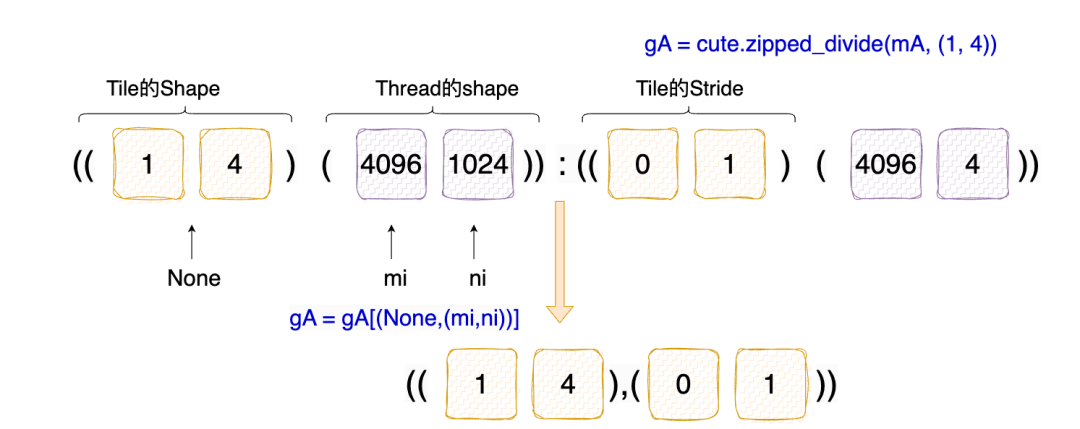

 ## 使用 zipped_divide保证线程访问元素的连续性

 zipped_divide 是唯一能够保证每个线程访问的元素在内存中连续排列的分块操作。
 操作：
    先按 tiler 把每个维度拆成“tile 内”和“tile 外”，再把所
    有“tile 内维度”打包成 mode0、把所有“tile 外维度”打包成 mode1；新 stride 是从原 stride 推导出来的（不会搬数据）


示例：
    - 原始 mA：shape=(8192,4096)，stride=(4096,1)


    - tiler=(1,4)：
        - tile 形状：(1,4)；tile 网格形状：(8192,4096/4=1024)
        - tile 内 stride：理论上是 (4096,1)，但因为第一维大小是 1（索引永远为 0），CuTe 会把它规约成 0，所以打印成 ((0,1))
        - tile 外 stride：(4096*1, 1*4) = (4096,4)

        
    - 所以打印的 gA 正好是：((1,4),(8192,1024)):((0,1),(4096,4))

手工去处理Thread domain的Layout映射

```python
    mi = thread_idx // n
    ni = thread_idx % n
    
    a[(None, (mi, ni))].load()
```

In [29]:
@cute.kernel
def vector_elementwise_add_kernel(
    gA: cute.Tensor,
    gB: cute.Tensor,
    gC: cute.Tensor,
):
    tidx, _, _ = cute.arch.thread_idx()
    bidx, _, _ = cute.arch.block_idx()
    bdimx, _, _ = cute.arch.block_dim()
    
    thread_idx = bidx * bdimx + tidx

    m, n = gA.shape[1]
    print(f"THread domain m={m} , n={n}")
    ni = thread_idx % n
    mi = thread_idx // n

#*                                   gA = gA[(None, (mi, ni))]
#*                                                    ↓
#*                                       ((   [  1 ]  [  4 ]   ), (   [  0 ]  [  1 ]   ))
#*
    a_val = gA[(None, (mi, ni))].load()    #! TensorSSA
    b_val = gB[(None, (mi, ni))].load()

    print(f"[DSL INFO] sliced gA = {gA[(None, (mi, ni))]}")
    print(f"[DSL INFO] sliced gB = {gB[(None, (mi, ni))]}")

    gC[(None), (mi, ni)] = a_val + b_val


@cute.jit
def vectorized_elementwise_add(
    mA: cute.Tensor,
    mB: cute.Tensor,
    mC: cute.Tensor
):
    threads_per_block = 256

    gA = cute.zipped_divide(mA, (1, 4))
    gB = cute.zipped_divide(mB, (1, 4))
    gC = cute.zipped_divide(mC, (1, 4))
    print(f"[DSL INFO] Tiled Tensors:")
    print(f"[DSL INFO] gA = {gA}")
    print(f"[DSL INFO] gB = {gB}")
    print(f"[DSL INFO] gC = {gC}")
    
    vector_elementwise_add_kernel(gA, gB, gC).launch(
        grid=(cute.size(gC, mode=[1]) // threads_per_block, 1, 1),
        block=(threads_per_block, 1, 1)
    )

In [63]:
M,N= 8192,4096
a = torch.randn(M, N, device="cuda", dtype=torch.float32)
b = torch.randn(M, N, device="cuda", dtype=torch.float32)
c = torch.zeros(M, N, device="cuda", dtype=torch.float32)

a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)

compiled_func = cute.compile(vectorized_elementwise_add, a_, b_, c_)
compiled_func(a_, b_, c_)

# verify correctness
torch.testing.assert_close(c, a + b)

benchmark(partial(compiled_func, a_, b_, c_), num_warmups=5, num_iters=100)

[DSL INFO] Tiled Tensors:
[DSL INFO] gA = tensor<ptr<f32, gmem, align<16>> o ((1,4),(8192,1024)):((0,1),(4096,4))>
[DSL INFO] gB = tensor<ptr<f32, gmem, align<16>> o ((1,4),(8192,1024)):((0,1),(4096,4))>
[DSL INFO] gC = tensor<ptr<f32, gmem, align<16>> o ((1,4),(8192,1024)):((0,1),(4096,4))>
THread domain m=8192 , n=1024
[DSL INFO] sliced gA = tensor<ptr<f32, gmem, align<16>> o ((1,4)):((0,1))>
[DSL INFO] sliced gB = tensor<ptr<f32, gmem, align<16>> o ((1,4)):((0,1))>
Average execution time: 0.0944ms
Performance (GFLOPS): 355.3254GFLOPS
Effective Memory Bandwidth: 4263.90 GB/s


### 2.3 TV Layout 思路


##### （1）对于原始张量 A 可以按照某种方式将其切分为很多个大小为`(TileM, TileN)`的Tile. 我们将其定义为 tiler_mn 的未知变量

```python
gA = cute.zipped_divide(mA, tiler_mn) # ((TileM, TileN), (RestM, RestN))
```

##### （2）这样可以通过每个线程块`(Thread block)`去处理一个小为`(TileM, TileN)`的Tile

可以通过这个Layout的第二个Mode即(RestM, RestN)进行索引。即在其Grid内划分为(RestM, RestN)个block来处理.

```python
cute.size(gC, mode=[1])
```

##### （3）在Kernel中, 我们可以通过block-idx获取出该block对应的子张量

即`gA[((None, None), bidx)]`, 这会返回一个单个 `(TileM, TileN)` 子张量的线程块局部视图.

```python
blk_coord = ((None, None), bidx) 
blkA = gA[blk_coord] # (TileM, TileN) -> physical address
```

##### （4）确定线程块处理的`tile`大小后，进一步划分线程 `layout` (thr_layout)

例如一个SM包含4个warp, 每个warp包含32个cuda core, 累计4x32个cuda core. 那么可以把线程按照`(4,32):(32:1)`的方式构建layout, 即让一个 Warp (32个线程) 的线程按行连续加载数据, 4个不同的warp分别读取不同的行, 这样我们就获得了


```python
thr_layout= cute.make_layout((4, 32), stride=(32, 1))
```


##### （5）对每个线程需要处理的数据, 我们可以构造一个 `Value Layout`

例如我们为了保证向量化的LD/ST, 至少一行要有连续的4个数据, 例如`val_layout = cute.make_layout((4, 4), stride=(4, 1))`
即一个row-major的值矩阵


##### （6）根据 `tv_layout` 重建整个 `Tile` 的 `layout`

`核心: 通过复合 block索引 和 block内的tv_layout， 就能得到实际的地址`


In [32]:
@cute.jit
def tv_layout():
    thr_layout = cute.make_layout((4, 32), stride=(32, 1))
    val_layout = cute.make_layout((4, 4), stride=(4, 1))
    layout_mn = cute.raked_product(thr_layout,val_layout)
    print(f"layout mn->thr_idx,val_idx {layout_mn}")

    thr_size = cute.size(thr_layout)
    val_size = cute.size(val_layout)
    print(f"thrsize: {thr_size} val_size: {val_size}")

    # 创建一个代表Tile坐标域的临时布局
    tmp = cute.make_layout((thr_size,val_size))
    
    # 通过求逆和组合, 构造从 (thr_idx, val_idx) 到 (M,N) 的映射
    layout_tv = cute.composition(
        cute.right_inverse(layout_mn), tmp
    )
    print(f"layout_tv: {layout_tv}")
    
    # 计算Tiler,即(TileM,TileN)
    tiler_mn = cute.product_each(layout_mn.shape)
    return (tiler_mn,layout_tv)

tv_layout()

layout mn->thr_idx,val_idx ((4,4),(4,32)):((512,32),(128,1))
thrsize: 128 val_size: 16
layout_tv: ((32,4),(4,4)):((64,4),(16,1))


((16, 128), <cutlass.cute.core._Layout at 0x7f35101b6690>)

In [55]:
@cute.kernel
def elementwise_add_kernel_tv(
    gA: cute.Tensor,
    gB: cute.Tensor,
    gC: cute.Tensor,
    tv_layout: cute.Layout
):
    tidx, _, _, = cute.arch.thread_idx()
    bidx, _, _, = cute.arch.block_idx()

    #--------------------------------
    # slice for thread-block level view
    #--------------------------------

    blk_coord = ((None, None), bidx)

    # logical coord -> address
    blkA = gA[blk_coord]        # (TileM, TileN) -> physical address
    blkB = gB[blk_coord]        # (TileM, TileN) -> physical address
    blkC = gC[blk_coord]        # (TileM, TileN) -> physical address

    #--------------------------------
    # compose for thread-index & value-index to physical mapping
    #--------------------------------
    # blockA:    (TileM, TileN) -> physical address
    # tv_layout: (tid, vid)     -> (TileM, TileN)
    # tidfrgA = blkA o tv_layout
    # tidfrgA:   (tid, vid) -> physical address
    tidfrgA = cute.composition(blkA, tv_layout)
    tidfrgB = cute.composition(blkB, tv_layout)
    tidfrgC = cute.composition(blkC, tv_layout)
    
    print(f"Composed with TV layout:")
    print(f"  tidfrgA: {tidfrgA.type}")

    #--------------------------------
    # slice for thread-level view
    #--------------------------------
    # `None` represent slice of the entire per-thread data
    thr_coord = (tidx, None)
                           
    
    # slice for threads: vid -> address  
    thrA = tidfrgA[thr_coord]   # (V) -> physical address
    thrB = tidfrgB[thr_coord]   # (V) -> physical address
    thrC = tidfrgC[thr_coord]   # (V) -> physical address
    print(f"thrA : {thrA}")

    thrC[None] = thrA.load() + thrB.load()  # TensorSSA


@cute.jit
def elementwise_add_tv(
    mA: cute.Tensor,
    mB: cute.Tensor,
    mC: cute.Tensor
):
    # mA layout: (M, N):(N, 1)
    # TV layout map thread & value index to (16, 256) logical tile
    #  - contiguous thread index maps to mode-1 because input layout is contiguous on
    #     mode-1 for coalesced load-store
    #  - each thread load 8 contiguous element each row and load 4 rows
    thr_layout = cute.make_layout((4, 32), stride=(32, 1))
    val_layout = cute.make_layout((4, 4), stride=(4, 1))
    tiler_mn, tv_layout = cute.make_layout_tv(thr_layout, val_layout)
    print(f"Tiler: {tiler_mn}")
    print(f"TV Layout: {tv_layout}")

    gA = cute.zipped_divide(mA, tiler_mn)
    gB = cute.zipped_divide(mB, tiler_mn)
    gC = cute.zipped_divide(mC, tiler_mn)

    print(f"Tiled Input Tensors:")
    print(f"  gA: {gA.type}")
    print(f"  gB: {gB.type}")
    print(f"  gC: {gC.type}")

    print(f" block-size: {cute.size(gC, mode=[1])}, thread-size: {cute.size(tv_layout, mode=[0])}")

    # Launch the kernel asynchronously
    # Async token(s) can also be specified as dependencies
    elementwise_add_kernel_tv(
        gA, gB, gC, tv_layout
    ).launch(
        grid = [cute.size(gC, mode=[1]), 1, 1],
        block = [cute.size(tv_layout, mode=[0]), 1, 1],
    )

In [64]:
M,N = 8192,4096

a = torch.randn(M, N, device="cuda", dtype=torch.float32)
b = torch.randn(M, N, device="cuda", dtype=torch.float32)
c = torch.zeros(M, N, device="cuda", dtype=torch.float32)

a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)

elementwise_add_ = cute.compile(elementwise_add_tv, a_, b_, c_)
elementwise_add_(a_, b_, c_)

# verify correctness
torch.testing.assert_close(c, a + b)

benchmark(partial(elementwise_add_, a_, b_, c_), num_warmups=5, num_iters=200)

Tiler: (16, 128)
TV Layout: ((32,4),(4,4)):((64,4),(16,1))
Tiled Input Tensors:
  gA: !cute.memref<f32, gmem, align<16>, "((16,128),(512,32)):((4096,1),(65536,128))">
  gB: !cute.memref<f32, gmem, align<16>, "((16,128),(512,32)):((4096,1),(65536,128))">
  gC: !cute.memref<f32, gmem, align<16>, "((16,128),(512,32)):((4096,1),(65536,128))">
 block-size: 16384, thread-size: 128
Composed with TV layout:
  tidfrgA: !cute.memref<f32, gmem, align<16>, "((32,4),(4,4)):((4,16384),(1,4096))">
thrA : tensor<ptr<f32, gmem, align<16>> o ((4,4)):((1,4096))>
Average execution time: 0.0995ms
Performance (GFLOPS): 337.2570GFLOPS
Effective Memory Bandwidth: 4047.08 GB/s
